## About this notebook
I have used this notebook to develop deeper understanding of *convolutions* and *convolutional neural network*. This notebook studies **ResNet** and how it solved the network degradation problem with increasing network depth (channels). Resnet does this with shortcut connection or skip connections. There are some notes that explain this a bit, but i believe its best if one learns this themselves. The model uses 2 different blocks - *Basic* and *Bottlneck* depending upon the depth of the resnet, for resnet deeper than 50 layers it is necessary to save computational cost and hence the bottleneck trick - this is also explained a bit in the notebook. I have not trained any models for this one because the goal of this study is essential to understand cnns and it was made simpler with torch summary.

In [43]:
import torch
from torch import nn

In [33]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels=64,out_channels=64, stride=[1,1], down_sample=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.down_sample = down_sample
        if down_sample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)

            )

    def forward(self, x):
        input = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.down_sample:
            input = self.downsample(input)

        x += input
        x = self.relu(x)
        return x

# ResNet & Convolutional Neural Networks: Comprehensive Technical Summary

## 1. Architecture & Residual Learning

**Q: What is the "Degradation Problem" and how does ResNet solve it?**
* **The Problem**: In deep "plain" networks, adding more layers leads to higher training error, which is an optimization issue where deeper systems are harder to train.
* **The Solution**: ResNet introduces **Shortcut Connections** that allow the network to learn **Residual Mappings** ($F(x) = H(x) - x$).
* **Identity Mapping**: It is mathematically easier for an optimizer to push weights toward zero to achieve an identity mapping than to force a stack of non-linear layers to mimic the input $x$ perfectly.
* **Gradient Flow**: The addition operation acts as a "gradient highway," ensuring that early layers receive a strong signal during backpropagation.



**Q: Why use a "Projection" (1x1 Conv) for downsampling instead of just passing the input?**
* **Dimensionality Mismatch**: When the main path ($F(x)$) reduces spatial resolution (via stride) and increases channel depth, the raw input $x$ no longer matches for addition.
* **Re-formatting**: The $1 \times 1$ convolution acts as a "bridge," using a stride of 2 to match the spatial size and a specific number of filters to match the new channel depth.
* **Learned Identity**: While it adds a few parameters, the network trains these weights to be the most effective linear transformation of the input for that specific transition.



---

## 2. 3D Convolution & "The Weight Matrix"

**Q: If a kernel size is 3x3, why does a single filter have more than 9 weights?**
* **The 3D Cube**: A kernel must match the depth of the input. If the input has 64 channels, a $3 \times 3$ kernel is a cube of $3 \times 3 \times 64 = 576$ weights.
* **The Summation**: During the convolution, the filter performs an element-wise multiplication across all 576 values and sums them into a **single scalar** for that pixel.
* **1x1 Projection Weights**: In a $1 \times 1$ convolution, one filter is a cube of $1 \times 1 \times 64 = 64$ weights. This is why it’s called a "pointwise" projection; it mixes channels at a single point.



**Q: How do we get exactly 64 or 128 output channels?**
* **Filter Count**: The number of output channels is determined strictly by how many **unique 3D filters** you choose to slide across the image.
* **Stacking**: Filter #1 produces the first 2D output sheet, Filter #2 produces the second, and so on. Stacking these 64 unique sheets creates the 64-channel output.
* **Weight Tensor Shape**: Weights are stored as $(C_{out}, C_{in}, K_h, K_w)$.



---

## 3. Execution & Implementation

**Q: What happens when I call `model(input)` instead of `model.forward(input)`?**
* **The `__call__` Wrapper**: Calling the object directly triggers the `nn.Module.__call__` method, which manages internal state and "hooks" before executing your `forward` logic.
* **The Stack**: Execution is a "Russian Doll" stack: the model's `__call__` runs, then the block's `__call__` runs, and finally each layer's `__call__` runs down to the C++/CUDA math kernels.

**Q: Why can I reuse ReLU but not BatchNorm?**
* **Stateless vs. Stateful**: ReLU is a "stateless" mathematical function—it has no memory or weights. BatchNorm is "stateful" because it has learnable parameters ($\gamma, \beta$) and tracks running means/variances unique to its position in the network.

In [34]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels=64,out_channels=64, kerenel=[1,3,1], stride=[1,2,1], down_sample=False, down_sample_strid=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kerenel[0], stride=stride[0], bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kerenel[1], stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size=kerenel[2], stride=stride[2], bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.relu = nn.ReLU(inplace=True) # does it matter where this relu is defined in the order like this

        self.down_sample = down_sample
        if down_sample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*4, kernel_size=1, stride=down_sample_strid, bias=False),
                nn.BatchNorm2d(out_channels*4)

            )

    def forward(self, x):
        input = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        if self.down_sample:
            input = self.downsample(input)

        x += input
        x = self.relu(x)
        return x

In [35]:
class ResNet(nn.Module):

    def __init__(self,in_channels=3,num_residual_block=[3,4,6,3],num_class=1000,block_type='normal'):
        super(ResNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,64,7,2,3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool2d(3,2,1)

        if block_type.lower() == 'bottleneck':    
            self.resnet,outchannels = self.__bottlenecks(num_residual_block)
        else:
            self.resnet,outchannels = self.__layers(num_residual_block)
    

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=outchannels,out_features=num_class,bias=True)

        
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.resnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x 
    
    def __layers(self,num_residual_block):
        layer=[]
        # layer += [BasicBlock()]*num_residual_block[0]
        layer += [BasicBlock() for _ in range(num_residual_block[0])]
        inchannels=64
        for numOFlayers in num_residual_block[1:]:
            stride = [2,1] #updating the stride, the first layer of residual block
            # will have a stride of two and the 2nd layer of the residual block have 
            # a stride of 1
            downsample=True
            outchannels = inchannels*2
            for _ in range(numOFlayers):
                layer.append(BasicBlock(inchannels,outchannels,stride,down_sample=downsample))
                inchannels = outchannels
                downsample = False 
                stride=[1,1]
            
        return nn.Sequential(*layer),outchannels

    
    def __bottlenecks(self,numres):
        
        layer=[]
        
        stride = [1,1,1]
        dnStride=1
        inchan = 64
        for i,numOFlayers in enumerate(numres):
            dn_sample = True
            outchan = 64*(2**i)

            for _ in range(numOFlayers):
                layer+=[ 
                    Bottleneck(inchan,outchan,stride=stride,
                    down_sample=dn_sample,down_sample_strid=dnStride)
                ]
                inchan = outchan*4
                dn_sample = False
                stride = [1,1,1]   
            dn_sample=True 
            stride = [1,2,1]
            dnStride=2
            

        return nn.Sequential(*layer),inchan

# ResNet Implementation & Architectural Summary

### 1. The "Stem" (Initial Preparation)
* **Purpose**: Aggressively reduces high-resolution input (e.g., 224x224) and expands channels to 64 before entering expensive residual stages.
* **Output Shape Math**: The initial 7x7 conv (stride 2, padding 3) results in **112x112** because $O = \lfloor \frac{224 - 7 + (2 \times 3)}{2} \rfloor + 1 = 112$.
* **Parameter Count**: For `conv1` (7x7, 3 in, 64 out, bias=False), the math is $7 \times 7 \times 3 \times 64 = \mathbf{9,408}$.



---

### 2. The Residual Concept: Accumulation over Transformation
* **Identity vs. Change**: ResNet layers learn the **change** (residual $F(x)$) needed for the current state rather than a completely new representation.
* **No "Resetting"**: Because of the addition $x + F(x)$, information persists throughout the network; if a block learns nothing, the shortcut simply passes the existing data forward.
* **Feature Persistence**: The final signal is the original image plus hundreds of incremental refinements stacked on top of it.



---

### 3. BasicBlock vs. Bottleneck
* **BasicBlock**: Used in ResNet-18/34. Consists of two 3x3 convolutions.
* **Bottleneck**: Used in ResNet-50+. Uses a **1x1 (Squeeze) -> 3x3 (Process) -> 1x1 (Expand)** strategy to save computation by reducing channel depth before spatial work.
* **The "Balloon" Effect**: In Stage 1, the first block expands 64 to 256. Every subsequent block in that stage is a true bottleneck ($256 \rightarrow 64 \rightarrow 256$).



---

### 4. Dimensionality & Downsampling
* **Strict Addition**: For $x + F(x)$, the Batch, Channel, Height, and Width must match **exactly**.
* **Projection Shortcut**: Used only in the **first block of a stage** to fix mismatches when spatial size halves (Stride 2) and depth doubles.
* **Downsample Logic**: Subsequent blocks in a stage use **Identity Mapping** because shapes already match, saving millions of multiplications and preserving gradient flow.



---

### 5. Model Scaling & Naming
* **ResNet-18 Math**: Only weighted layers in the main path are counted. $1 (\text{stem}) + (2 \text{ layers/block} \times [2+2+2+2]) + 1 (\text{fc}) = 18$.
* **Channel Doubling**: We double channels as we halve resolution to maintain constant computational complexity and compensate for lost spatial detail.
* **Global Average Pooling**: Collapses the final 7x7 spatial grid into a single feature vector, removing spatial location but keeping the "rich" accumulated signal for the final classifier.

In [36]:
def  resnet18(**kwargs):
    return ResNet(num_residual_block=[2,2,2,2],**kwargs)

def resnet34(**kwargs):
    return ResNet(num_residual_block=[3,4,6,3],**kwargs)

def resnet50(**kwargs):
    return ResNet(num_residual_block=[3,4,6,3],block_type='bottleneck',**kwargs)

def resnet101(**kwargs):
    return ResNet(num_residual_block=[3,4,23,3],block_type='bottleneck',**kwargs)

def resnet152(**kwargs):
    return ResNet(num_residual_block=[3,8,36,3],block_type='bottleneck',**kwargs)

In [37]:
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

model118 = resnet18().to(device=device)
summary(model118, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [38]:
model34 = resnet34().to(device=device)
summary(model34,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [39]:
model50 = resnet50().to(device=device)
summary(model50,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [40]:
model101 = resnet101().to(device=device)
summary(model101,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [41]:
model152 = resnet152().to(device=device)
summary(model152,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

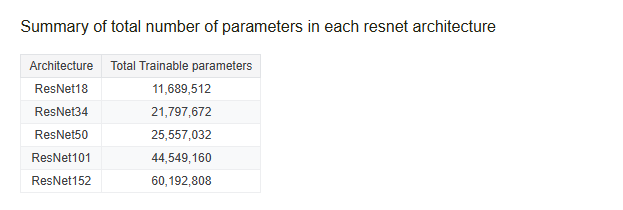